# Problem Statement:
---
The goal of this project is to give people an estimate of how much they need based on
their individual health situation. After that, customers can work with any health
insurance carrier and its plans and perks while keeping the projected cost from our
study in mind. This can assist a person in concentrating on the health side of an
insurance policy rather han the ineffective part.



# Dataset description:
---
1. Age: Person's age in years
2. Sex: Gender of the person or insurance holder(Female or Male)
3. BMI: Body mass index. The ideal range according to height and weight is 18.5 to 24.9
4. Children: Number of dependents
5. Smoker: Whether the insurance holder smokes or not
6. Region: Residential area of the person
7. Expenses: Individual medical costs billed by health insurance

In [34]:
!pip install opendatasets --upgrade --quiet
!pip install plotly --upgrade --quiet

^C


In [290]:
import os
import opendatasets as od

import warnings
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import matplotlib

%matplotlib inline

warnings.filterwarnings("ignore")

In [291]:
# the regression models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score

# feature-selection methods
from sklearn.feature_selection import SelectFromModel

### Data Ingestion

In [292]:
dataset_url = 'https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction?datasetId=233212&sortBy=voteCount&select=insurance.csv'

od.download(dataset_url)

# {"username":"satyanerurkar","key":"7d413ed8d2a25d9ade8669e4fcf96a57"}

Skipping, found downloaded files in ".\insurance-premium-prediction" (use force=True to force download)


In [293]:
data_dir = './insurance-premium-prediction'

os.listdir(data_dir)

['insurance.csv']

In [294]:
insurance_data_csv = data_dir + '/insurance.csv'
#concrete_data_csv="/config/workspace/notebook/concrete-compressive-strength-data-set/concrete_data.csv"

In [295]:
insurance_data = pd.read_csv(insurance_data_csv)

In [296]:
df=insurance_data.copy()

### Profile of the Data

In [297]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [298]:
print("This dataset contains {} rows and {} columns.".format(df.shape[0], df.shape[1]))

This dataset contains 1338 rows and 7 columns.


In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [300]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [301]:
df.describe(include='object').T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [302]:
# duplicate values check!

df.duplicated().sum()

1

In [303]:
# Dropping duplicate values
df.drop_duplicates(inplace=True)

In [304]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

**Observations:**
- This dataset contains 1338 rows and 7 columns.
- There are no null values in this dataset.
- There are 4 numeric as well as 3 categorical features present in this dataset.
- There was 1 duplicate row present in this dataset.

### Exploratory Data Analysis

<Figure size 2520x2520 with 0 Axes>

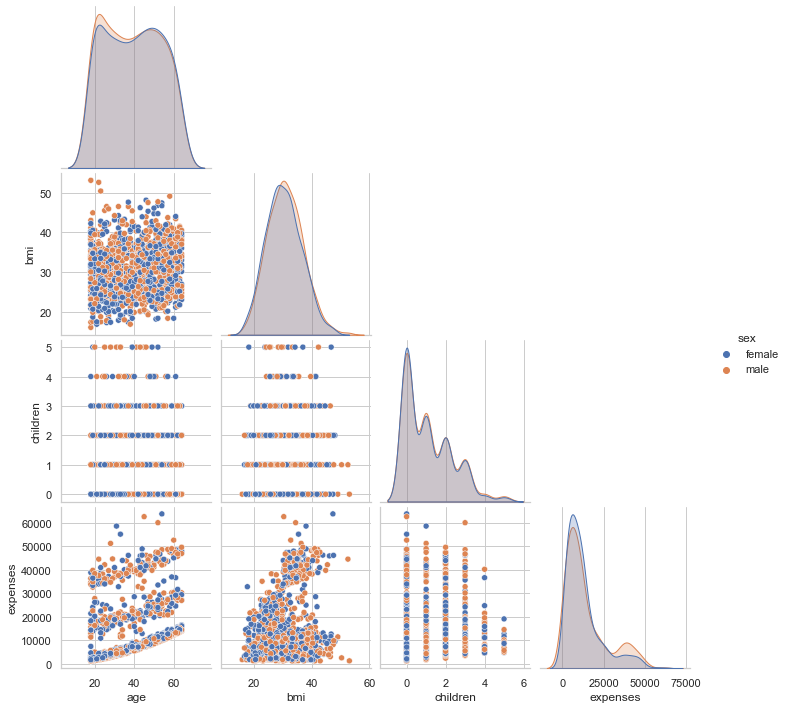

In [305]:
plt.figure(figsize=(35,35))
sns.pairplot(data=df, hue='sex', corner = True)

In [306]:
# Retrieving numerical columns from dataset
numeric_columns = [feature for feature in df.columns if df[feature].dtype != 'O']

In [307]:
# Retrieving categorical columns from dataset
categorical_columns = [feature for feature in df.columns if df[feature].dtype == 'O']

In [308]:
print(f"This data set contains {len(numeric_columns)} numerical columns: {numeric_columns}")

This data set contains 4 numerical columns: ['age', 'bmi', 'children', 'expenses']


In [309]:
print(f"This data set contains {len(categorical_columns)} categorical columns: {categorical_columns}")

This data set contains 3 categorical columns: ['sex', 'smoker', 'region']


In [310]:
# Displaying Skewness in the features.
df.skew()

age         0.054781
bmi         0.284463
children    0.937421
expenses    1.515391
dtype: float64

In [311]:
plt.figure(figsize=(15, 15), dpi=500)
plt.suptitle('Univariate Analysis', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_columns)):
    plt.subplot(2, 2, i+1)
    sns.distplot(x=df[numeric_columns[i]],kde=True)
    plt.axvline(df[numeric_columns[i]].mean(),linestyle="dashed",label="mean",color="k")
    plt.xlabel(numeric_columns[i])
    plt.legend(loc="best")
    plt.title(f"Distribution of {numeric_columns[i]}",color="navy")
    plt.tight_layout()

In [312]:
import scipy.stats as stats

def diagnostic_plots(df, variable):
    '''
    function to plot a histogram and a Q-Q plot
    side by side, for a certain variable
    '''
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.xlabel(variable)
    plt.title('Histogram')

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(variable)
    plt.title('Q-Q plot')
    plt.show()

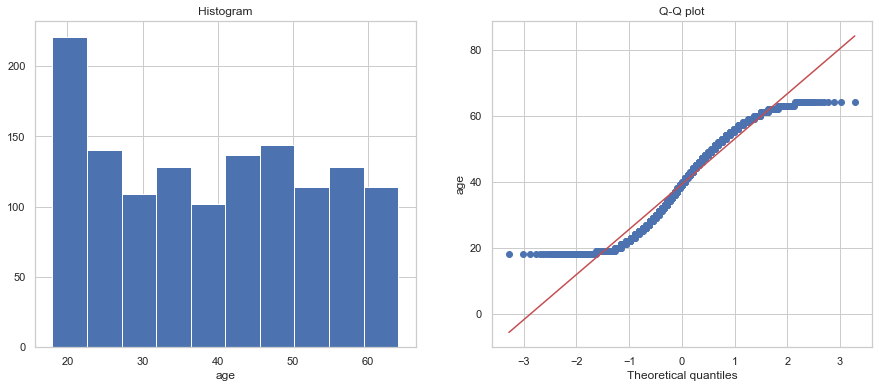

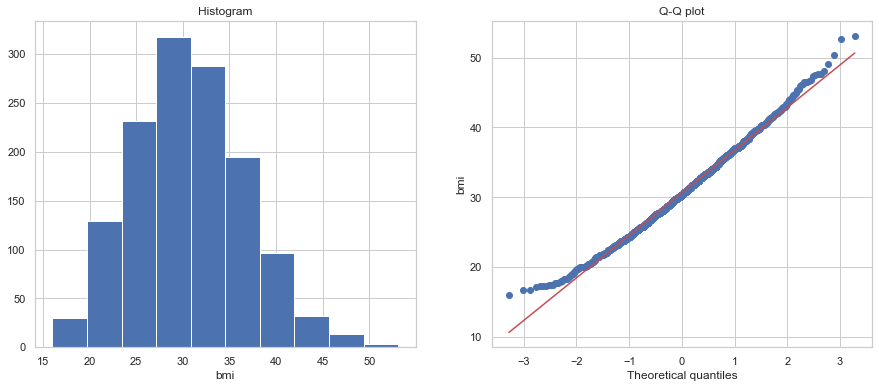

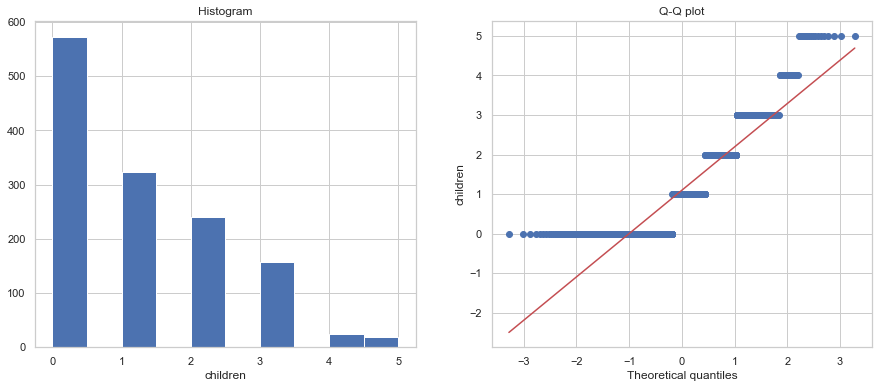

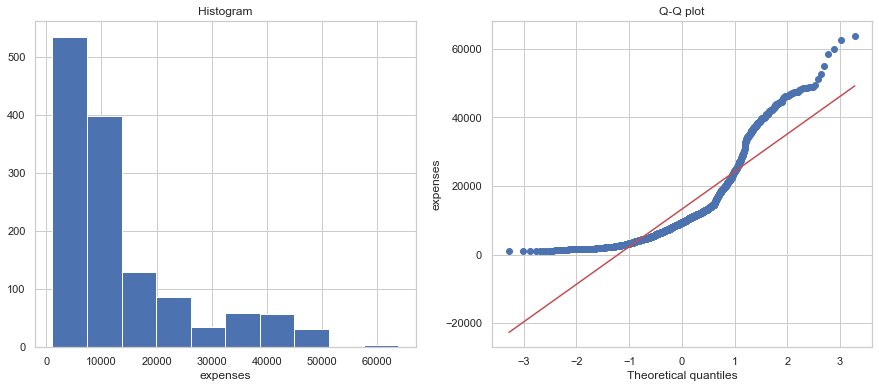

In [313]:
for col in numeric_columns:
    diagnostic_plots(df, col)

In [314]:
def age_group(X):
    if X in range(18,20):
        return '18-20'
    if X in range(20,30):
        return '20-30'
    if X in range(30,40):
        return '30-40'
    if X in range(40,50):
        return '40-50'
    elif X in range(50,60):
        return '50-60'
    else:
        return '60+'
    
df['age_group']=df['age'].apply(age_group)

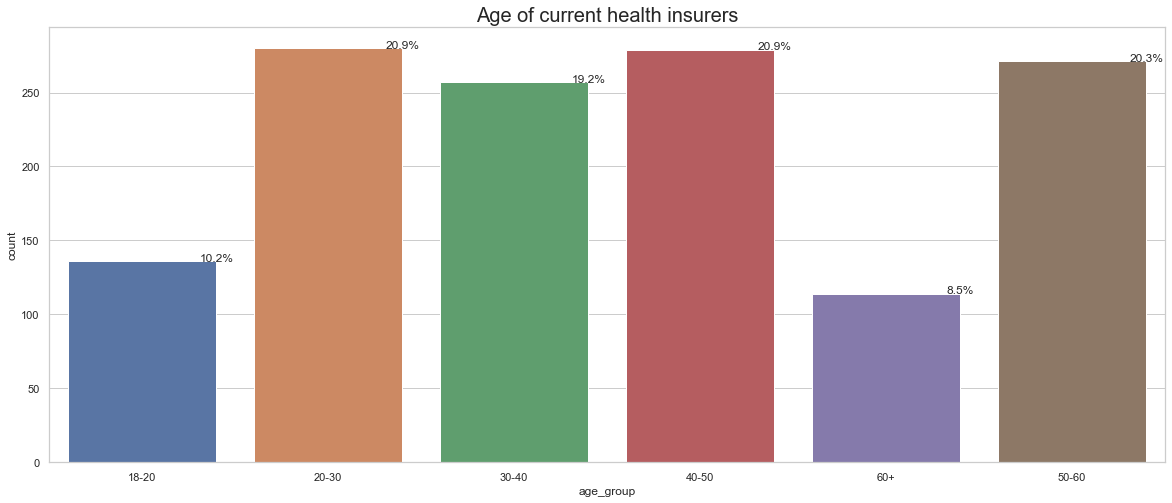

In [315]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,8))
total = float(len(df))
ax = sns.countplot(x="age_group", data=df)
plt.title('Age of current health insurers', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

df.drop(["age_group"], axis=1, inplace=True)

In [316]:
fig = px.histogram(df, x='region', color="sex")
fig.update_layout(bargap =0.2)
fig.show()

In [317]:
fig = px.histogram(df, x='sex')
fig.update_layout(bargap =0.2)
fig.show()

In [318]:
fig = px.histogram(df, x='smoker')
fig.update_layout(bargap =0.2)
fig.show()

In [319]:
fig = px.histogram(df, x='children')
fig.update_layout(bargap =0.2)
fig.show()

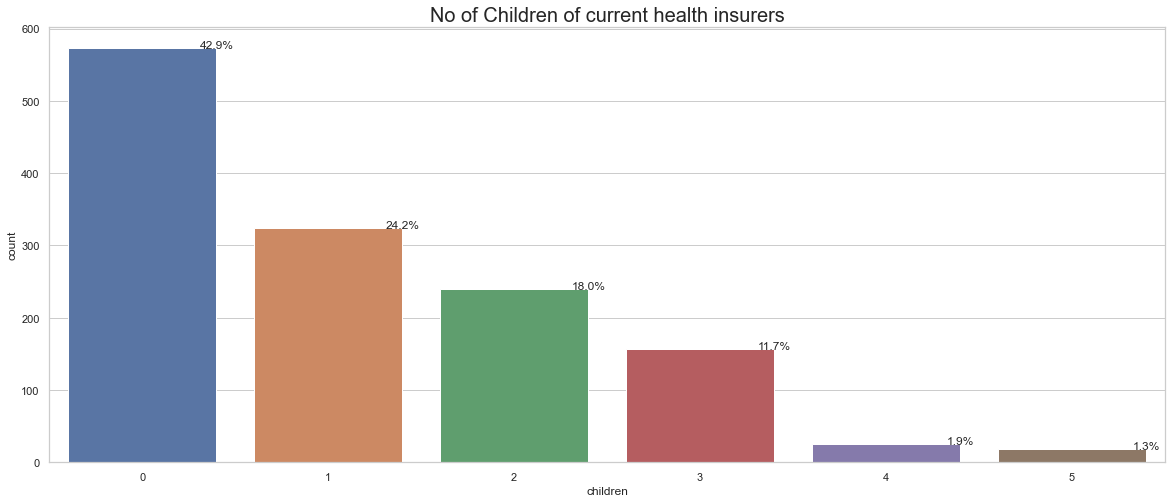

In [320]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,8))
total = float(len(df))
ax = sns.countplot(x="children", data=df)
plt.title('No of Children of current health insurers', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

**Observations**:
- we can see that region feature is slightly imbalanced with southeast having few more records.
- gender feature is balanced. While smoker feature is highly imbalanced with most records having non-smokers.
- We can see that there are more individual without any offspring while there are 18 individuals with 5 childern.

In [321]:
# check relation between age and expenses
fig = px.scatter(df, x="age", y="expenses", color="region", symbol="sex", hover_data=['bmi', 'smoker', 'children'])
fig.show()

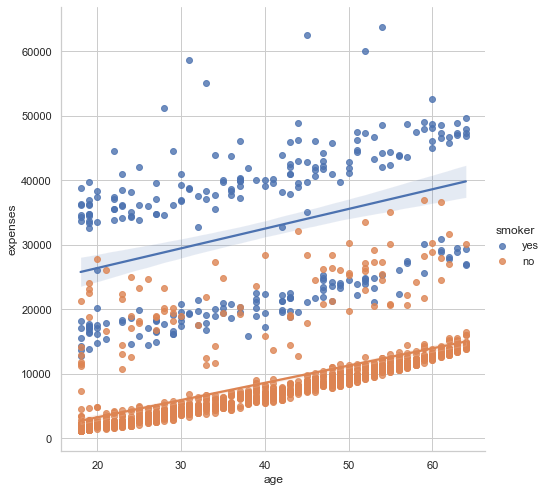

In [322]:
sns.lmplot(data=df, x='age', y='expenses',hue="smoker",height = 7)

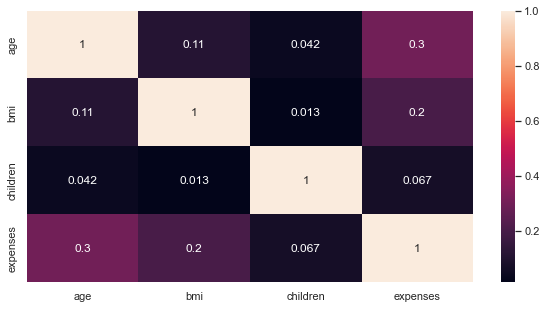

In [323]:
# Set the width and height of the figure
plt.figure(figsize=(10,5))

corr = df.corr()
ax = sns.heatmap(corr,annot=True)

In [324]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

In [325]:
# One hot encoding on categorical columns
df = pd.get_dummies(df,columns = ['sex', 'smoker', 'region'],drop_first = True)

It's important to note that the scaler should only be fit to the training data, as the test data should not be used to fit any part of the model. This ensures that the model is evaluated on unseen data, and helps to prevent overfitting.

In [327]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X=df.drop(columns=['expenses'], axis=1)
y=df['expenses']

In [328]:
def evaluate_model(true, predicted, X_test):
    '''
    This function takes in true values and predicted values
    Returns: Mean Squared Error, Mean Absolute Error, Root Mean Squared Error, R2 Score, Adjusted R2 Score
    '''
    mse = mean_squared_error(true, predicted) # Calculate Mean Squared Error
    mae = mean_absolute_error(true, predicted) # Calculate Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(true, predicted)) # Calculate Root Mean Squared Error
    score = r2_score(true, predicted) # Calculate R2 Score
    Adj_score = 1 - (1-score)*(len(true)-1)/(len(true)-X_test.shape[1]-1) #Calculate Adj R2 Score
    return mse, mae, rmse, score, Adj_score

In [329]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    train_Mean_Squared_Error=[]
    train_Mean_Absolute_Error=[]
    train_Root_Mean_Squared_Error=[]
    train_R2_Score=[]
    train_Adjusted_R2_Score=[]
    test_Mean_Squared_Error=[]
    test_Mean_Absolute_Error=[]
    test_Root_Mean_Squared_Error=[]
    test_R2_Score=[]
    test_Adjusted_R2_Score=[]
    models_list = []

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    # Scaling the dataset
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        # Calculate Mean Squared Error, Mean Absolute Error, Root Mean Squared Error, R2 Score, Adjusted R2 Score
        model_train_mse, model_train_mae, model_train_rmse,\
        model_train_r2_score ,model_train_adj_r2_score =evaluate_model(y_train, y_train_pred, X_train)

        train_Mean_Squared_Error.append(model_train_mse)
        train_Mean_Absolute_Error.append(model_train_mae)
        train_Root_Mean_Squared_Error.append(model_train_rmse)
        train_R2_Score.append(model_train_r2_score)
        train_Adjusted_R2_Score.append(model_train_adj_r2_score)

        # Test set performance
        model_test_mse, model_test_mae, model_test_rmse,\
        model_test_r2_score, model_test_adj_r2_score = evaluate_model(y_test, y_test_pred, X_test)

        test_Mean_Squared_Error.append(model_test_mse)
        test_Mean_Absolute_Error.append(model_test_mae)
        test_Root_Mean_Squared_Error.append(model_test_rmse)
        test_R2_Score.append(model_test_r2_score)
        test_Adjusted_R2_Score.append(model_test_adj_r2_score)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Mean Squared Error: {:.4f}".format(model_train_mse))
        print('- Mean Absolute Error: {:.4f}'.format(model_train_mae)) 
        print('- Root Mean Squared Error: {:.4f}'.format(model_train_rmse))
        print('- R2 Score: {:.4f}'.format(model_train_r2_score))
        print('- Adjusted R2 Score: {:.4f}'.format(model_train_adj_r2_score))

        print('-'*30)

        print('Model performance for Test set')
        print('- Mean Squared Error: {:.4f}'.format(model_test_mse))
        print('- Mean Absolute Error: {:.4f}'.format(model_test_mae))
        print('- Root Mean Squared Error: {:.4f}'.format(model_test_rmse))
        print('- R2 Score: {:.4f}'.format(model_test_r2_score))
        print('- Adjusted R2 Score: {:.4f}'.format(model_test_adj_r2_score))

        print('='*35)
        print('\n')

        
    train_report = pd.DataFrame({'Model': models_list, 'Train Mean Squared Error': train_Mean_Squared_Error, 
                        'Train Mean Absolute Error': train_Mean_Absolute_Error,  
                        'Train Root Mean Squared Error': train_Root_Mean_Squared_Error,
                        'Train R Squared': train_R2_Score, 
                        'Train_Adjusted R2 score': train_Adjusted_R2_Score})

    test_report = pd.DataFrame({'Model': models_list,'Test Mean Squared Error': test_Mean_Squared_Error,
                        'Test Mean Absolute Error': test_Mean_Absolute_Error,  
                        'Test Root Mean Squared Error': test_Root_Mean_Squared_Error,
                        'Test_R Squared': test_R2_Score, 
                        'Test Adjusted R2 score': test_Adjusted_R2_Score})   
    '''
    test_report = pd.DataFrame({'Model': models_list, 'Test_Mean Squared Error': test_Mean_Squared_Error, 'Mean Absolute Error': test_Mean_Absolute_Error, 
                           'Root Mean Squared Error': test_Root_Mean_Squared_Error, 'R Squared': test_R2_Score, 
                           'Adjusted R2 score': test_Adjusted_R2_Score})
    #report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])

    report = pd.concat([train_report, test_report], axis=1)
    '''
    return train_report, test_report 

In [330]:
# Dictionary which contains models for experiment
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state = 1),
    "Lasso Regression": Lasso(random_state = 1),
    "Support Vector Regression": SVR(kernel='linear'),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state = 1),
    "Bagging Regressor": BaggingRegressor(random_state = 1), 
    "Ada-Boost Regressor": AdaBoostRegressor(random_state = 1),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state = 1),
    "XGB Regressor": XGBRegressor()
}

In [331]:
train_report_df, test_report_df = evaluate_models(X,y, models)

Linear Regression
Model performance for Training set
- Mean Squared Error: 36975927.8416
- Mean Absolute Error: 4181.8256
- Root Mean Squared Error: 6080.7835
- R2 Score: 0.7299
- Adjusted R2 Score: 0.7279
------------------------------
Model performance for Test set
- Mean Squared Error: 35481471.5959
- Mean Absolute Error: 4177.2676
- Root Mean Squared Error: 5956.6326
- R2 Score: 0.8069
- Adjusted R2 Score: 0.8009


Ridge Regression
Model performance for Training set
- Mean Squared Error: 36976020.6098
- Mean Absolute Error: 4182.8397
- Root Mean Squared Error: 6080.7911
- R2 Score: 0.7299
- Adjusted R2 Score: 0.7279
------------------------------
Model performance for Test set
- Mean Squared Error: 35515902.7145
- Mean Absolute Error: 4179.8437
- Root Mean Squared Error: 5959.5220
- R2 Score: 0.8067
- Adjusted R2 Score: 0.8008


Lasso Regression
Model performance for Training set
- Mean Squared Error: 36975943.7555
- Mean Absolute Error: 4181.7460
- Root Mean Squared Error: 6080.78

In [332]:
train_report_df

,Model,Train Mean Squared Error,Train Mean Absolute Error,Train Root Mean Squared Error,Train R Squared,Train_Adjusted R2 score
0,Linear Regression,3.697593e+07,4181.825636,6080.783489,0.729935,0.727896
1,Ridge Regression,3.697602e+07,4182.839731,6080.791117,0.729934,0.727896
2,Lasso Regression,3.697594e+07,4181.745957,6080.784798,0.729934,0.727896
3,Support Vector Regression,1.383175e+08,7570.663458,11760.844332,-0.010246,-0.017870
4,Decision Tree Regressor,0.000000e+00,0.000000,0.000000,1.000000,1.000000
5,Bagging Regressor,4.621008e+06,1091.474835,2149.652930,0.966249,0.965994
6,Ada-Boost Regressor,2.570912e+07,4081.373927,5070.415773,0.812225,0.810808
7,Gradient Boosting Regressor,1.553547e+07,2159.432938,3941.506281,0.886532,0.885675
8,XGB Regressor,7.251511e+05,504.550203,851.558068,0.994704,0.994664


In [333]:
test_report_df

,Model,Test Mean Squared Error,Test Mean Absolute Error,Test Root Mean Squared Error,Test_R Squared,Test Adjusted R2 score
0,Linear Regression,3.548147e+07,4177.267596,5956.632572,0.806910,0.800946
1,Ridge Regression,3.551590e+07,4179.843668,5959.522021,0.806723,0.800753
2,Lasso Regression,3.548880e+07,4177.435834,5957.247633,0.806870,0.800905
3,Support Vector Regression,1.914900e+08,8689.314557,13837.991788,-0.042088,-0.074276
4,Decision Tree Regressor,3.815840e+07,2963.877127,6177.248887,0.792342,0.785928
5,Bagging Regressor,2.568503e+07,2815.656030,5068.040212,0.860222,0.855905
6,Ada-Boost Regressor,2.641362e+07,4259.669496,5139.417824,0.856257,0.851817
7,Gradient Boosting Regressor,1.827638e+07,2523.249757,4275.088482,0.900540,0.897468
8,XGB Regressor,2.797412e+07,3102.639577,5289.056900,0.847765,0.843063


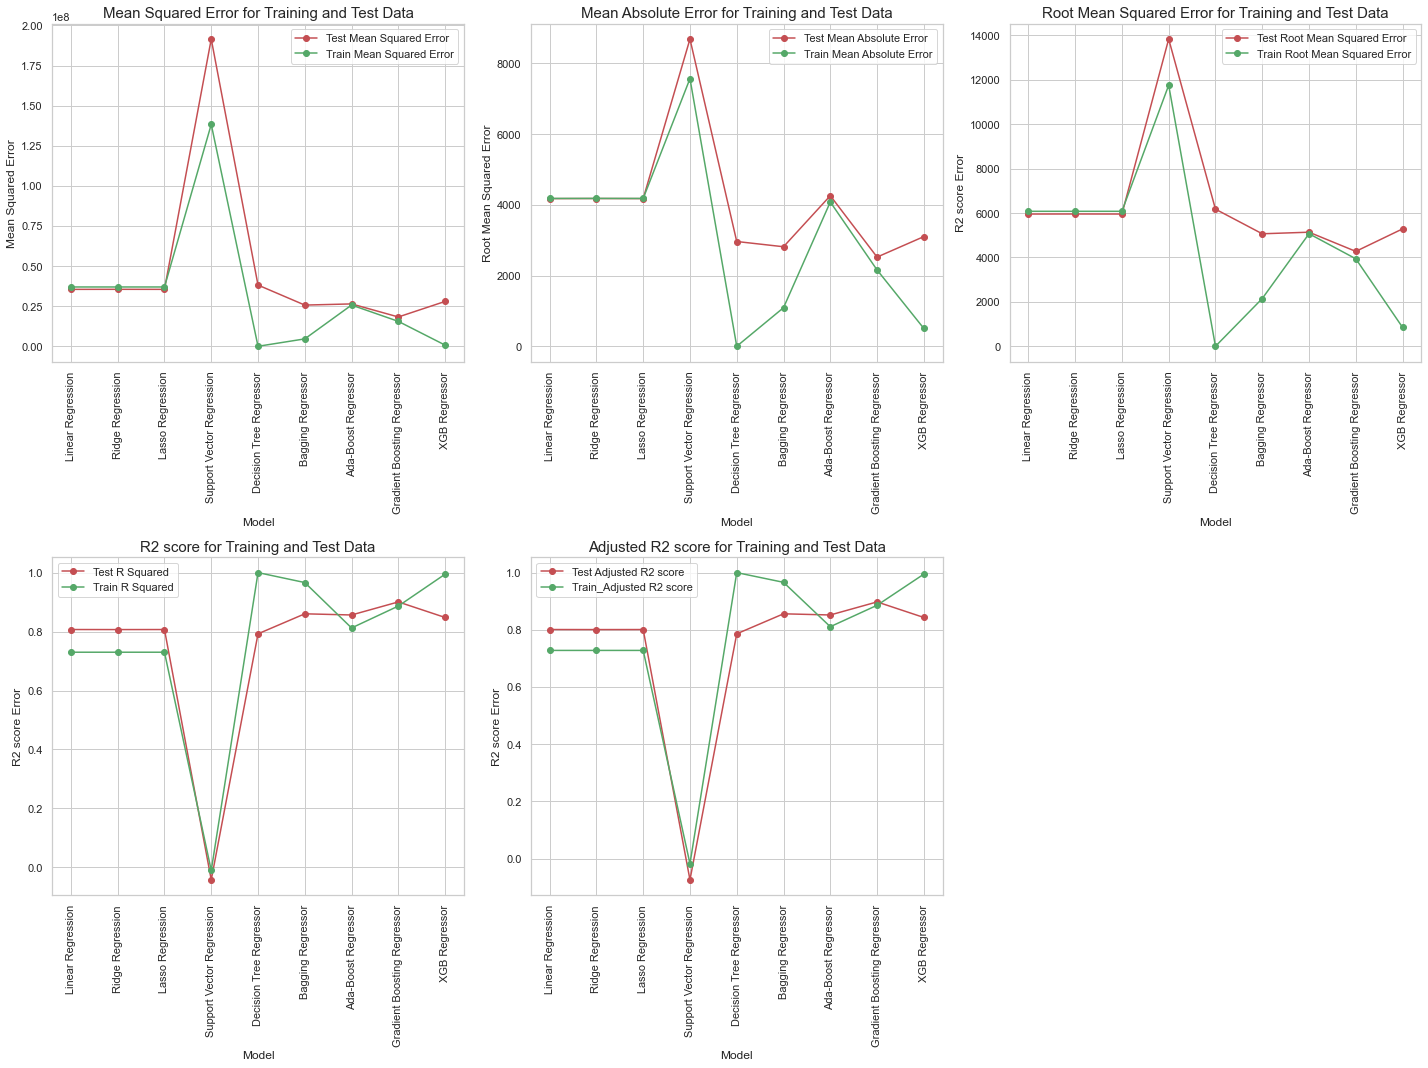

In [336]:
plt.figure(figsize = (20,15))

## Mean Squared Error comparision
plt.subplot(2,3,1)
plt.plot(test_report_df['Model'], test_report_df['Test Mean Squared Error'], marker = 'o',color = 'r', label ='Test Mean Squared Error')
plt.plot(train_report_df['Model'], train_report_df['Train Mean Squared Error'], marker = 'o',color = 'g', label ='Train Mean Squared Error')
plt.xlabel("Model", fontsize= 12)
plt.ylabel("Mean Squared Error", fontsize= 12)
plt.title("Mean Squared Error for Training and Test Data", fontsize= 15)
plt.xticks(rotation = 90) # Rotating the x labels
plt.legend()
plt.tight_layout()

## Mean Absolute Error Comparision
plt.subplot(2,3,2)
plt.plot(test_report_df['Model'], test_report_df['Test Mean Absolute Error'], marker = 'o',color = 'r', label ='Test Mean Absolute Error')
plt.plot(train_report_df['Model'], train_report_df['Train Mean Absolute Error'], marker = 'o',color = 'g', label ='Train Mean Absolute Error')
plt.xlabel("Model", fontsize= 12)
plt.ylabel("Root Mean Squared Error", fontsize= 12)
plt.title("Mean Absolute Error for Training and Test Data", fontsize= 15)
plt.xticks(rotation = 90) # Rotating the x labels
plt.legend()
plt.tight_layout()

## Root Mean Squared Error comparison
plt.subplot(2,3,3)
plt.plot(test_report_df['Model'], test_report_df['Test Root Mean Squared Error'], marker = 'o',color = 'r', label ='Test Root Mean Squared Error')
plt.plot(train_report_df['Model'], train_report_df['Train Root Mean Squared Error'], marker = 'o',color = 'g', label ='Train Root Mean Squared Error')
plt.xlabel("Model", fontsize= 12)
plt.ylabel("R2 score Error", fontsize= 12)
plt.title("Root Mean Squared Error for Training and Test Data", fontsize= 15)
plt.xticks(rotation = 90) # Rotating the x labels
plt.legend()
plt.tight_layout()

## Root Mean Squared Error comparison
plt.subplot(2,3,4)
plt.plot(test_report_df['Model'], test_report_df['Test_R Squared'], marker = 'o',color = 'r', label ='Test R Squared')
plt.plot(train_report_df['Model'], train_report_df['Train R Squared'], marker = 'o',color = 'g', label ='Train R Squared')
plt.xlabel("Model", fontsize= 12)
plt.ylabel("R2 score Error", fontsize= 12)
plt.title("R2 score for Training and Test Data", fontsize= 15)
plt.xticks(rotation = 90) # Rotating the x labels
plt.legend()
plt.tight_layout()

## Root Mean Squared Error comparison
plt.subplot(2,3,5)
plt.plot(test_report_df['Model'], test_report_df['Test Adjusted R2 score'], marker = 'o',color = 'r', label ='Test Adjusted R2 score')
plt.plot(train_report_df['Model'], train_report_df['Train_Adjusted R2 score'], marker = 'o',color = 'g', label ='Train_Adjusted R2 score')
plt.xlabel("Model", fontsize= 12)
plt.ylabel("R2 score Error", fontsize= 12)
plt.title("Adjusted R2 score for Training and Test Data", fontsize= 15)
plt.xticks(rotation = 90) # Rotating the x labels
plt.legend()
plt.tight_layout()


plt.show()

In [356]:
#create the hyperparameter grid

param_grid = {
'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
'n_estimators': [50, 100, 150, 200, 250, 300],
'max_depth': [2, 3, 4, 5, 6, 7, 8]
}

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [357]:
# create the model
hpt_model = GradientBoostingRegressor()

In [358]:
from sklearn.model_selection import GridSearchCV

# create the grid search object
grid_search = GridSearchCV(hpt_model, param_grid, cv=10, n_jobs=-1, verbose=1)

In [359]:
# fit the grid search object to the training data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             verbose=1)

In [360]:
# print the best parameters
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}


In [361]:
# create the model with the best parameters
final_model = GradientBoostingRegressor(n_estimators=grid_search.best_params_['n_estimators'], 
                                        max_depth=grid_search.best_params_['max_depth'],
                                        learning_rate=grid_search.best_params_['learning_rate'])

In [362]:
# fit the model to the training data
final_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=200)

In [363]:
# evaluate the model on the test data
print(final_model.score(X_test, y_test))

0.8979260661468592


In [364]:
y_pred = grid_search.predict(X_test)

In [365]:
print('Mean Squared Error is: ', mean_squared_error(y_test,y_pred))
print('Mean Absolute Error is: ', mean_absolute_error(y_test,y_pred))
print('Root Mean Squared Error is: ',np.sqrt(mean_squared_error(y_test,y_pred)))
print('Accuracy is: {} %'.format(round((r2_score(y_test, y_pred))*100,3)))
score = round((r2_score(y_test, y_pred))*100,3)
print('R2 Adjusted score is: {} %'.format(1 - (1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)))

Mean Squared Error is:  18756704.78125713
Mean Absolute Error is:  2561.1819873430386
Root Mean Squared Error is:  4330.901151175945
Accuracy is: 89.793 %
R2 Adjusted score is: 92.53564092664094 %
